# 1. Data Pre-analyzing

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from kolzur_filter import kz_filter
import matplotlib.pyplot as plt
import math
from datetime import timedelta
from datetime import datetime

## 1.1. Reading Data

**Data:** *2018.01.01 1:00 ~ 2022.12.31 23:00*

### 1.1.1. Weather AWS Data

From Yongsan(location code = 415)

In [2]:
colnames_AWS = ["locCode", "time", "temp", "windDir", "windSpd", "precip", "groundP", "seaP", "humid", "rad", "sunShine"]

def climate_data_merging(locCode):
    climate_data_2018 = pd.read_csv(
        "./data_weatherAWS/SURFACE_AWS_%d_HR_2018_2018_2019.csv"%locCode,
        header = 0,
        names = colnames_AWS
    )

    climate_data_2019 = pd.read_csv(
        "./data_weatherAWS/SURFACE_AWS_%d_HR_2019_2019_2020.csv"%locCode,
        header = 0,
        names = colnames_AWS
    )

    climate_data_2020 = pd.read_csv(
        "./data_weatherAWS/SURFACE_AWS_%d_HR_2020_2020_2021.csv"%locCode,
        header = 0,
        names = colnames_AWS
    )

    climate_data_2021 = pd.read_csv(
        "./data_weatherAWS/SURFACE_AWS_%d_HR_2021_2021_2022.csv"%locCode,
        header = 0,
        names = colnames_AWS
    )

    climate_data_2022 = pd.read_csv(
        "./data_weatherAWS/SURFACE_AWS_%d_HR_2022_2022_2023.csv"%locCode,
        header = 0,
        names = colnames_AWS
    )
    
    return pd.concat([climate_data_2018, climate_data_2019, climate_data_2020, climate_data_2021, climate_data_2022])

climate_data_yongsan = climate_data_merging(415)
climate_data_yeongdeungpo = climate_data_merging(510)
climate_data_cemetery = climate_data_merging(889)


print(climate_data_yongsan)
print(climate_data_yeongdeungpo)
print(climate_data_cemetery)

      locCode              time  temp  windDir  windSpd  precip  groundP  \
0         415   2018-01-01 1:00  -1.5     31.7      0.9     0.0      NaN   
1         415   2018-01-01 2:00  -1.3      0.0      0.3     0.0      NaN   
2         415   2018-01-01 3:00  -2.2     16.6      0.8     0.0      NaN   
3         415   2018-01-01 4:00  -1.8    336.7      0.6     0.0      NaN   
4         415   2018-01-01 5:00  -2.2      5.8      0.5     0.0      NaN   
...       ...               ...   ...      ...      ...     ...      ...   
8754      415  2022-12-31 19:00  -0.4     35.6      0.6     0.0   1025.6   
8755      415  2022-12-31 20:00  -1.1     24.2      1.0     0.0   1025.3   
8756      415  2022-12-31 21:00  -1.5      0.0      0.2     0.0   1025.4   
8757      415  2022-12-31 22:00  -1.6      0.0      0.0     0.0   1025.6   
8758      415  2022-12-31 23:00  -1.6      0.0      0.4     0.0   1025.8   

        seaP  humid  rad  sunShine  
0        NaN    NaN  0.0       0.0  
1        NaN 

### 1.1.2 Water Level Data

In [3]:
colnames_waterLvl = ["date"]
for i in range(1, 25):
    colnames_waterLvl.append("lvl%02d"%i)

water_level = pd.read_csv(
    "./data_waterLvl/수위_시자료_서울시(한강대교)_2018-2022.csv",
    header = 0,
    names = colnames_waterLvl
)

print(water_level.head())

         date  lvl01  lvl02  lvl03  lvl04  lvl05  lvl06  lvl07  lvl08  lvl09  \
0  2022-12-31   0.55   0.55   0.60   0.59   0.56   0.57   0.56   0.55   0.56   
1  2022-12-30   0.72   0.87   0.79   0.75   0.74   0.71   0.68   0.67   0.65   
2  2022-12-29   1.08   0.97   0.92   0.89   0.84   0.79   0.77   0.73   0.70   
3  2022-12-28   1.48   1.29   1.17   1.07   1.01   0.95   0.89   0.84   0.80   
4  2022-12-27   1.48   1.31   1.19   1.10   1.04   0.98   0.92   0.87   0.81   

   ...  lvl15  lvl16  lvl17  lvl18  lvl19  lvl20  lvl21  lvl22  lvl23  lvl24  
0  ...   0.54   0.54   0.54   0.54   0.54   0.53   0.53   0.53   0.53    NaN  
1  ...   0.58   0.58   0.58   0.57   0.56   0.56   0.56   0.56   0.56   0.55  
2  ...   0.61   0.60   0.60   0.59   0.58   0.57   0.57   0.57   0.57   0.56  
3  ...   0.70   0.68   0.67   0.65   0.64   0.62   0.61   0.61   0.60   0.83  
4  ...   0.79   0.74   0.72   0.69   0.66   0.65   0.64   0.63   1.09   1.52  

[5 rows x 25 columns]


## 1.2 Data Reshaping

### 1.2.1. Weather AWS Data

To pick the weater data of interested region

In [4]:
def drop_column(climate_data):
    climate_data.drop(["locCode", "groundP", "seaP", "humid", "rad", "sunShine"], axis = 1, inplace = True)
drop_column(climate_data_yongsan)
drop_column(climate_data_yeongdeungpo)
drop_column(climate_data_cemetery)

In [5]:
def full_time(climate_data):
    climate_data['time'] = pd.to_datetime(climate_data['time'], format='%Y-%m-%d %H:%M')
    time_indx = pd.date_range("2018-01-01 1:00:00", "2022-12-31 23:00:00", freq = "H")
    tmp_time = pd.DataFrame({"time": time_indx})
    new_climate_data = pd.merge(tmp_time, climate_data, left_on = "time", right_on = "time", how = "left")
    return new_climate_data

climate_data_yongsan = full_time(climate_data_yongsan)
climate_data_yeongdeungpo = full_time(climate_data_yeongdeungpo)
climate_data_cemetery = full_time(climate_data_cemetery)


In [6]:
climate_data_yongsan.to_csv('AWS_415.csv', index=False)
climate_data_yeongdeungpo.to_csv('AWS_510.csv', index=False)
climate_data_cemetery.to_csv('AWS_889.csv', index=False)

In [7]:
print(climate_data_yongsan)
print(climate_data_yeongdeungpo)
print(climate_data_cemetery)

                     time  temp  windDir  windSpd  precip
0     2018-01-01 01:00:00  -1.5     31.7      0.9     0.0
1     2018-01-01 02:00:00  -1.3      0.0      0.3     0.0
2     2018-01-01 03:00:00  -2.2     16.6      0.8     0.0
3     2018-01-01 04:00:00  -1.8    336.7      0.6     0.0
4     2018-01-01 05:00:00  -2.2      5.8      0.5     0.0
...                   ...   ...      ...      ...     ...
43818 2022-12-31 19:00:00  -0.4     35.6      0.6     0.0
43819 2022-12-31 20:00:00  -1.1     24.2      1.0     0.0
43820 2022-12-31 21:00:00  -1.5      0.0      0.2     0.0
43821 2022-12-31 22:00:00  -1.6      0.0      0.0     0.0
43822 2022-12-31 23:00:00  -1.6      0.0      0.4     0.0

[43823 rows x 5 columns]
                     time  temp  windDir  windSpd  precip
0     2018-01-01 01:00:00  -0.9      0.0      0.3     0.0
1     2018-01-01 02:00:00  -0.8      0.0      0.4     0.0
2     2018-01-01 03:00:00  -0.9    283.3      0.5     0.0
3     2018-01-01 04:00:00  -1.3      0.0      

### 1.2.2. Water Level Data

To narrower the pivot of the data

In [8]:
water_level = pd.wide_to_long(water_level, ["lvl"], i = "date", j = "hours")
water_level.sort_values(by = ["date", "hours"], axis = 0, inplace = True)
water_level.reset_index(drop = False, inplace = True)
water_level['hours'].loc[water_level['hours'] == 24] = 0 #change 24h to 0h
water_level['date'] = pd.to_datetime(water_level['date'], format='%Y-%m-%d')
water_level['date'].loc[water_level['hours'] == 0] += timedelta(days = 1)
water_level["time"] = water_level["date"].astype(str) + " " + water_level["hours"].astype(str) + ":00"
water_level['time'] = pd.to_datetime(water_level['time'], format='%Y-%m-%d %H:%M')
water_level = water_level[:-1]

water_level.head(30)

/tmp/ipykernel_1206/4090021239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_level['hours'].loc[water_level['hours'] == 24] = 0 #change 24h to 0h
/tmp/ipykernel_1206/4090021239.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_level['date'].loc[water_level['hours'] == 0] += timedelta(days = 1)


,date,hours,lvl,time
0,2018-01-01,1,0.78,2018-01-01 01:00:00
1,2018-01-01,2,0.75,2018-01-01 02:00:00
2,2018-01-01,3,0.73,2018-01-01 03:00:00
3,2018-01-01,4,0.70,2018-01-01 04:00:00
4,2018-01-01,5,0.69,2018-01-01 05:00:00
5,2018-01-01,6,0.67,2018-01-01 06:00:00
6,2018-01-01,7,0.65,2018-01-01 07:00:00
7,2018-01-01,8,0.77,2018-01-01 08:00:00
8,2018-01-01,9,0.77,2018-01-01 09:00:00
9,2018-01-01,10,0.78,2018-01-01 10:00:00


## 1.3. Plotting the Data

### 1.3.1. Weather AWS Data

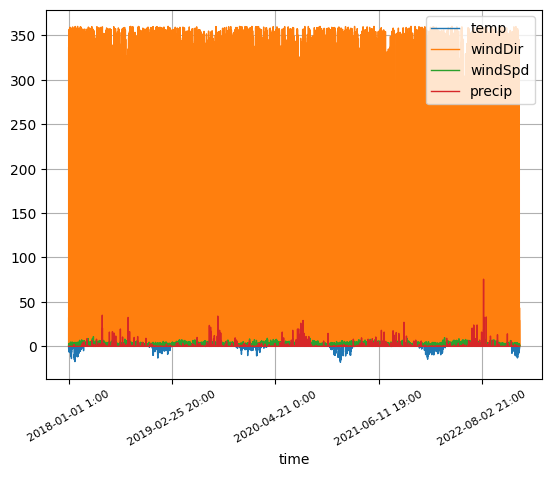

In [78]:
climate_data.plot(
    kind = "line",
    x = "time",
    y = ["temp", "windDir", "windSpd", "precip"],
    lw = 1,
    grid = True
)
plt.xticks(rotation = 30, fontsize = 8)
plt.show()

# The y-axis of each parameter is unified without normalization .. bad graph

### 1.3.2. Water Level Data

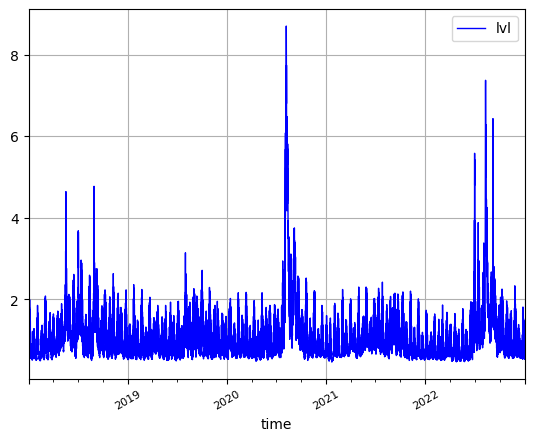

In [12]:
water_level.plot(
    kind = "line", 
    x = "time", y = "lvl",
    color = "blue",
    lw = 1,
    grid = True,
)
plt.xticks(rotation = 30, fontsize = 8)
plt.show()

<Axes: xlabel='time'>

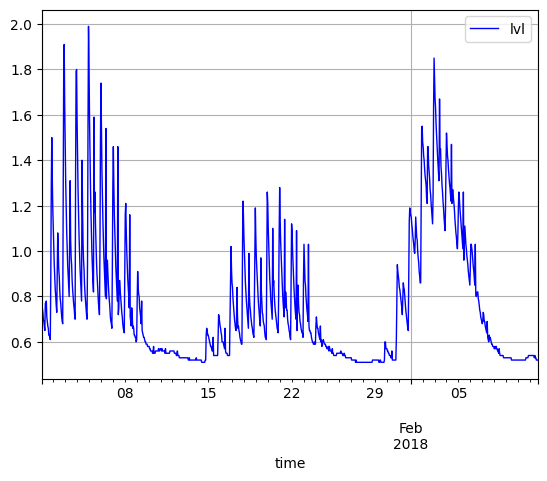

In [54]:
water_level.iloc[:1000].plot(
    kind = "line", 
    x = "time", y = "lvl",
    color = "blue",
    lw = 1,
    grid = True,
)

## 1.4. Data preprocessing

### 1.4.1. Feature Engineering

한강대교와 동서를 잇는 선 사이 각도는 약 62도이므로 이를 고려하여 풍향 데이터 변환  
북풍 0도, 동풍 90도, 남풍 180도, 서풍 270도

In [9]:
climate_data_yongsan["windDir"]

0         31.7
1          0.0
2         16.6
3        336.7
4          5.8
         ...  
43818     35.6
43819     24.2
43820      0.0
43821      0.0
43822      0.0
Name: windDir, Length: 43823, dtype: float64

In [9]:
def wind_dir_triangulation(climate_data):
    climate_data["horizon_dir"] = (climate_data["windDir"]-28).map(math.radians).map(math.cos) #다리 방향
    climate_data["vertical_dir"] = (climate_data["windDir"]-28).map(math.radians).map(math.sin) #다리 수직 방향 (물 방향)
    climate_data.drop(["windDir"], axis = 1, inplace = True)
wind_dir_triangulation(climate_data_yongsan)
wind_dir_triangulation(climate_data_yeongdeungpo)
wind_dir_triangulation(climate_data_cemetery)

In [10]:
print(climate_data_yongsan.head())
print(climate_data_yeongdeungpo.loc[6109])
print(climate_data_yongsan.loc[6108])

                 time  temp  windSpd  precip  horizon_dir  vertical_dir
0 2018-01-01 01:00:00  -1.5      0.9     0.0     0.997916      0.064532
1 2018-01-01 02:00:00  -1.3      0.3     0.0     0.882948     -0.469472
2 2018-01-01 03:00:00  -2.2      0.8     0.0     0.980271     -0.197657
3 2018-01-01 04:00:00  -1.8      0.6     0.0     0.625243     -0.780430
4 2018-01-01 05:00:00  -2.2      0.5     0.0     0.925871     -0.377841
time            2018-09-12 14:00:00
temp                           26.9
windSpd                         2.5
precip                          0.0
horizon_dir               -0.694658
vertical_dir                0.71934
Name: 6109, dtype: object
time            2018-09-12 13:00:00
temp                           25.8
windSpd                         2.2
precip                          0.0
horizon_dir                0.957822
vertical_dir               0.287361
Name: 6108, dtype: object


### 1.4.2. Missing Value Imputation

#### 1.4.2.1. Weather AWS data

The example of the location of NA:

In [12]:
climate_data_yongsan.loc[climate_data_yongsan['windSpd'].isna()]

,time,temp,windSpd,precip,horizon_dir,vertical_dir
528,2018-01-23 01:00:00,-5.4,NaN,0.0,NaN,NaN
529,2018-01-23 02:00:00,-7.2,NaN,0.0,NaN,NaN
530,2018-01-23 03:00:00,-8.0,NaN,0.0,NaN,NaN
531,2018-01-23 04:00:00,-8.6,NaN,0.0,NaN,NaN
532,2018-01-23 05:00:00,-9.4,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...
32485,2021-09-15 14:00:00,29.1,NaN,0.0,NaN,NaN
35063,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
39080,2022-06-17 09:00:00,20.8,NaN,0.0,NaN,NaN
43552,2022-12-20 17:00:00,1.1,NaN,0.0,NaN,NaN


In [12]:
climate_data_yongsan.isnull().sum()

time            0
temp            0
windSpd         0
precip          0
horizon_dir     0
vertical_dir    0
dtype: int64

* precip/horizontalDir/verticalDir: applied *moving average* based on the prior data
* temp/windSpd: applied *linear interpolation*

In [11]:
def missingImput_climate(df):
    i = 0
    while df.isnull().values.any():
        print(i, end = "\r")
        i += 1
        df['precip'] = df[['precip']].rolling(window = 3, min_periods = 1).mean()
        df['horizon_dir'] = df[['horizon_dir']].rolling(window = 3, min_periods = 1).mean()
        df['vertical_dir'] = df[['vertical_dir']].rolling(window = 3, min_periods = 1).mean()
        df['temp'] = df[['temp']].interpolate().values
        df['windSpd'] = df[['windSpd']].interpolate().values
    print("\n")
    return

missingImput_climate(climate_data_yongsan)
missingImput_climate(climate_data_yeongdeungpo)
missingImput_climate(climate_data_cemetery)

41

41

35



In [13]:
print(climate_data_yongsan.isnull().sum())
print(climate_data_yeongdeungpo.isnull().sum())
print(climate_data_cemetery.isnull().sum())

time            0
temp            0
windSpd         0
precip          0
horizon_dir     0
vertical_dir    0
dtype: int64
time            0
temp            0
windSpd         0
precip          0
horizon_dir     0
vertical_dir    0
dtype: int64
time            0
temp            0
windSpd         0
precip          0
horizon_dir     0
vertical_dir    0
dtype: int64


#### 1.4.2.2 Water Level Data

In [14]:
index_num = water_level.index[water_level['lvl'].isna() == True]
for num in index_num:
    if num == 0:
        water_level['lvl'][num] = water_level['lvl'][num + 1]
    elif num == len(water_level) - 1:
        water_level['lvl'][num] = water_level['lvl'][num - 1]
    else:
        water_level['lvl'][num] = (water_level['lvl'][num + 1] + water_level['lvl'][num - 1])/2

/tmp/ipykernel_1206/702953331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_level['lvl'][num] = (water_level['lvl'][num + 1] + water_level['lvl'][num - 1])/2


In [15]:
water_level.to_csv('water_level_copy.csv')

## 1.5. Stationarity Test

### stationary test

In [42]:
from statsmodels.tsa.stattools import adfuller, kpss

In [51]:
#adf test

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    #timeseries.iloc[:, 0] = pd.to_numeric(timeseries.iloc[:, 0])
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.DataFrame({
        "Test Statistic": dftest[0],
        "p-value": dftest[1],
        "#Lags Used": dftest[2],
        "Number of Observations Used": dftest[3]
    }, index = [0])
    
    return dfoutput
    

print("-----------")
# adf_test(climate_data_yongsan['temp'])
pd.concat([adf_test(water_level['lvl']), adf_test(climate_data_yongsan['temp'])])
# adf_test(climate_data_yongsan['precip'])
# adf_test(climate_data_yeongdeungpo['temp'])
# adf_test(climate_data_yeongdeungpo['precip'])
# adf_test(climate_data_cemetery['temp'])
# adf_test(climate_data_cemetery['precip'])
#'Cause p-value < 0.05, we can reject H0 (the data is not stationary)

-----------
Results of Dickey-Fuller Test:
Results of Dickey-Fuller Test:


,Test Statistic,p-value,#Lags Used,Number of Observations Used
0,-10.287594,3.640424e-18,54,43768
0,-5.080732,1.532506e-05,55,43767


In [325]:
#kpss test

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
kpss_test(water_level['lvl'])
kpss_test(climate_data_yongsan['temp'])
kpss_test(climate_data_yongsan['precip'])
kpss_test(climate_data_yeongdeungpo['temp'])
kpss_test(climate_data_yeongdeungpo['precip'])
kpss_test(climate_data_cemetery['temp'])
kpss_test(climate_data_cemetery['precip'])
#'Cause p-value > 0.05, we cannot reject H0 (the data 'is' stationary)

Results of KPSS Test:
Test Statistic             0.250298
p-value                    0.100000
Lags Used                119.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test:
Test Statistic             0.424471
p-value                    0.066607
Lags Used                119.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test:


/tmp/ipykernel_846/292045148.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/tmp/ipykernel_846/292045148.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Test Statistic             0.329571
p-value                    0.100000
Lags Used                114.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test:
Test Statistic             0.437148
p-value                    0.061143
Lags Used                120.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test:
Test Statistic             0.307667
p-value                    0.100000
Lags Used                114.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of KPSS Test:
Test Statistic             0.444335
p-value                    0.058045
Lags Used                118.000000
Critical Value (10%)     

/tmp/ipykernel_846/292045148.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/tmp/ipykernel_846/292045148.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


## 1.6. Time Series Decomposition

### STL

<Axes: >

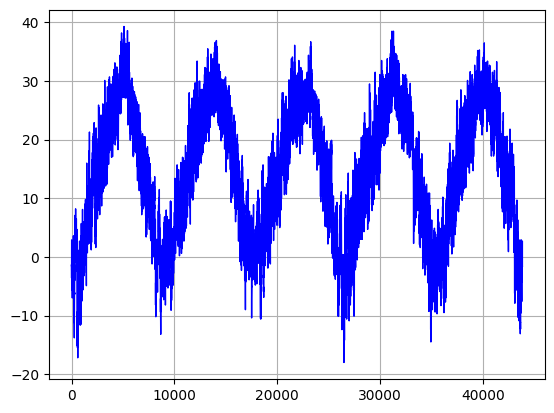

In [323]:
climate_data_yongsan['temp'].plot(
    kind = "line", 
    x = "time", y = "temp",
    color = "blue",
    lw = 1,
    grid = True,
)

<Axes: >

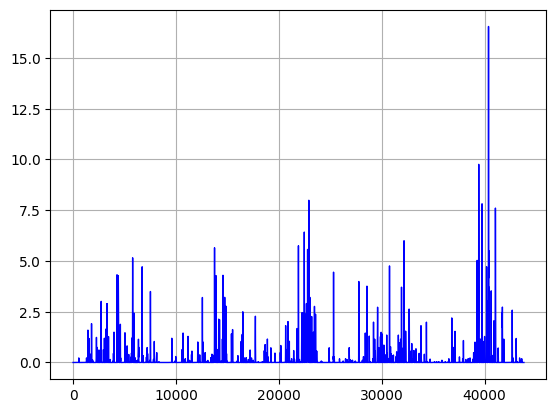

In [385]:
climate_data_yongsan['precip'].plot(
    kind = "line", 
    x = "time", y = "temp",
    color = "blue",
    lw = 1,
    grid = True,
)

In [16]:
from statsmodels.tsa.seasonal import STL

In [17]:
def my_stl(timeseries, name, period = 8760):
    stl_data = STL(timeseries, period).fit()
    stl_data.plot()
    stl_data_trend = stl_data.trend.to_frame()
    stl_data_seasonal = stl_data.seasonal.to_frame()
    stl_data_residual = stl_data.resid.to_frame()
    stl_data_df = pd.concat([stl_data_trend, stl_data_seasonal, stl_data_residual, climate_data_yongsan['time']], axis = 1)
    stl_data_df.to_csv(f'stl_{name}.csv')

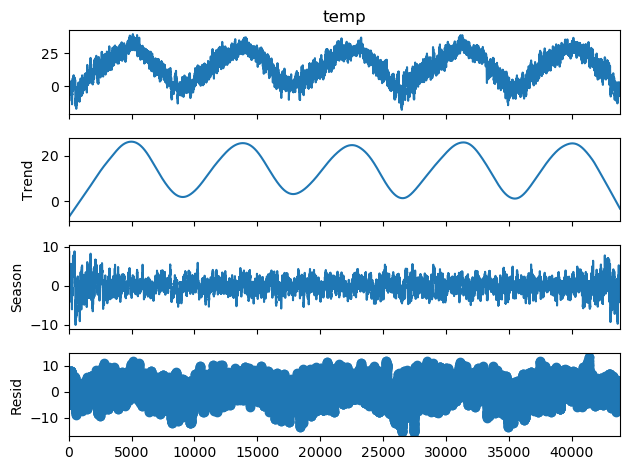

In [19]:
my_stl(climate_data_yongsan['temp'], 'yongsan_temp', 2190)

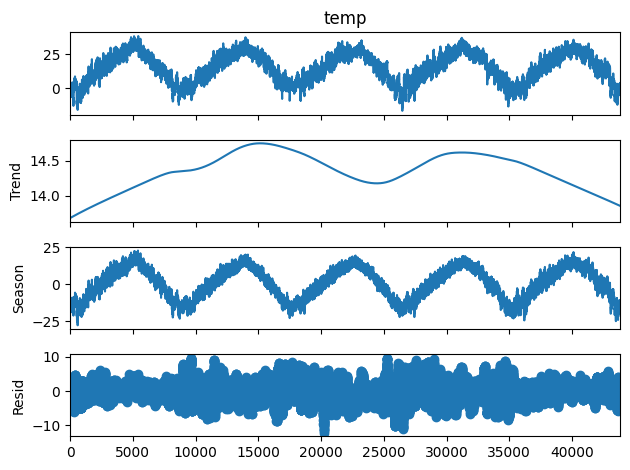

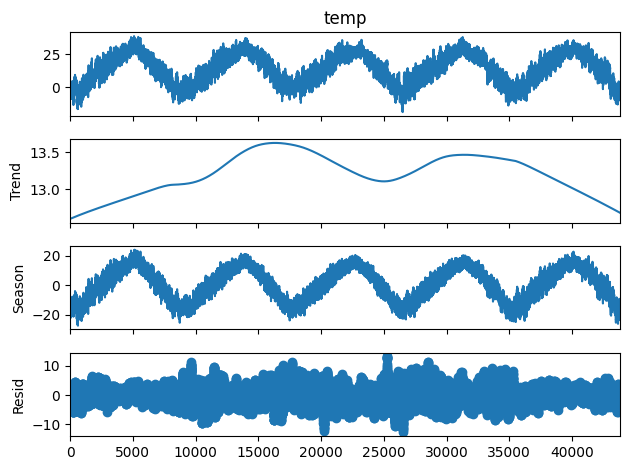

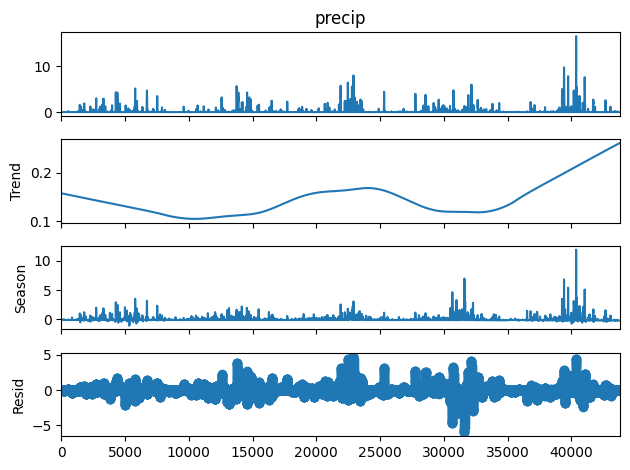

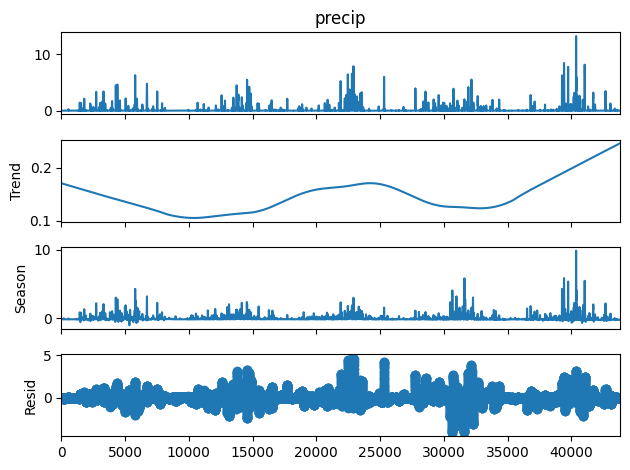

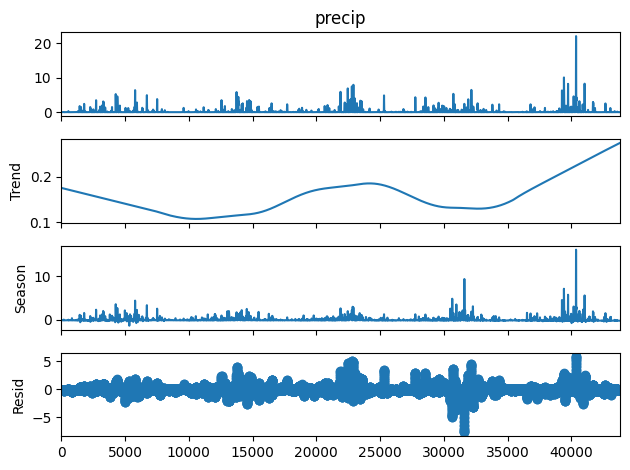

In [368]:
period = 2190
my_stl(climate_data_yongsan['temp'], 'yongsan_temp', period)
my_stl(climate_data_yeongdeungpo['temp'], 'yeongdeungpo_temp', period) #코드 잘 돌아가는지 확인하려면 period 자리에 1 대입
my_stl(climate_data_cemetery['temp'], 'cemetery_temp', period)
my_stl(climate_data_yongsan['precip'], 'yongsan_precip', period) #얘부터 period 확인! 8760이 잘 안 될 수도 있다
my_stl(climate_data_yeongdeungpo['precip'], 'yeongdeungpo_precip', period)
my_stl(climate_data_cemetery['precip'], 'cemetery_precip', period)
#풍향 풍속 수위에 대해서도 해조...

In [ ]:
my_stl(climate_data_yongsan['temp'], 'yongsan_temp', period)
my_stl(climate_data_yeongdeungpo['temp'], 'yeongdeungpo_temp', period) #코드 잘 돌아가는지 확인하려면 period 자리에 1 대입
my_stl(climate_data_cemetery['temp'], 'cemetery_temp', period)
my_stl(climate_data_yongsan['precip'], 'yongsan_precip', period) #얘부터 period 확인! 8760이 잘 안 될 수도 있다
my_stl(climate_data_yeongdeungpo['precip'], 'yeongdeungpo_precip', period)
my_stl(climate_data_cemetery['precip'], 'cemetery_precip', period)

### MSTL

<Axes: >

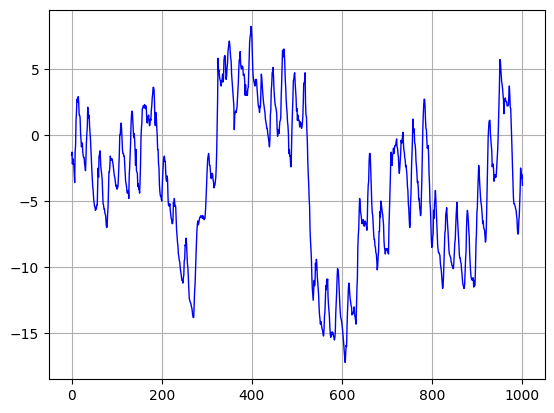

In [41]:
climate_data_yongsan['temp'].loc[:1000].plot(
    kind = "line", 
    x = "time", y = "temp",
    color = "blue",
    lw = 1,
    grid = True,
)

In [20]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

In [ ]:
mstl = MSTL(climate_data_yongsan['temp'], periods=[24, 24 * 365])
mstl_data = mstl.fit()
mstl_data.plot()

In [16]:
mstl_data_trend = mstl_data.trend
mstl_data_seasonal = mstl_data.seasonal
mstl_data_residual = mstl_data.resid
mstl_data_df = pd.concat([mstl_data_trend, mstl_data_seasonal, mstl_data_residual, climate_data_yongsan['time']], axis = 1)
name = 'yongsan_temp'
mstl_data_df.to_csv(f'mstl_{name}.csv')

In [60]:
def my_mstl(timeseries, name, periods = [24, 24*15, 24*365]):
    mstl = MSTL(timeseries, periods = periods)
    mstl_data = mstl.fit()
    mstl_data.plot()
    mstl_data_trend = mstl_data.trend
    mstl_data_seasonal = mstl_data.seasonal
    mstl_data_residual = mstl_data.resid
    mstl_data_df = pd.concat([mstl_data_trend, mstl_data_seasonal, mstl_data_residual, climate_data_yongsan['time']], axis = 1)
    mstl_data_df.to_csv(f'mstl_{name}.csv')

**CAUTION:** Each of the follwing chunks needs *approximately* AN HOUR to obtain the result.

In [ ]:
# TEMP
my_mstl(climate_data_yongsan['temp'], 'yongsan_temp')
my_mstl(climate_data_yeongdeungpo['temp'], 'yeongdeungpo_temp')
my_mstl(climate_data_cemetery['temp'], 'cemetery_temp')
print("----------")
# PRECIPITATION
my_mstl(climate_data_yongsan['precip'], 'yongsan_precip')
my_mstl(climate_data_yeongdeungpo['precip'], 'yeongdeungpo_precip')
my_mstl(climate_data_cemetery['precip'], 'cemetery_precip')
print("----------")

----------
----------
----------


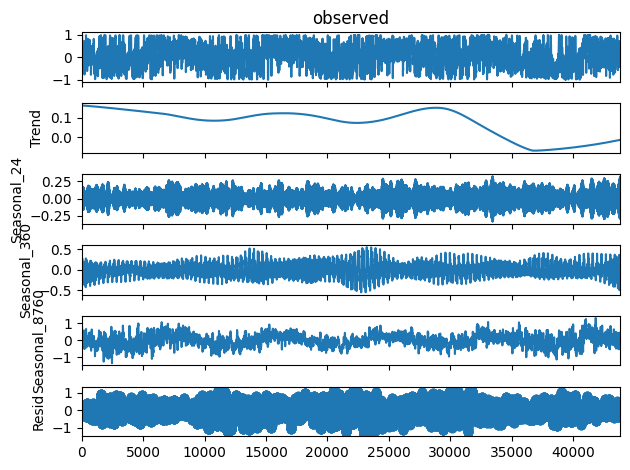

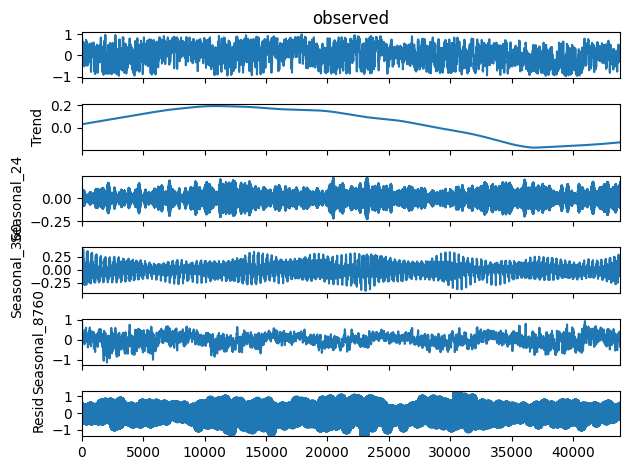

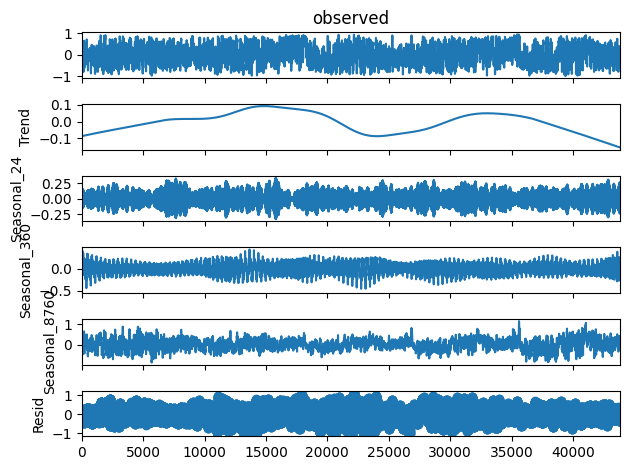

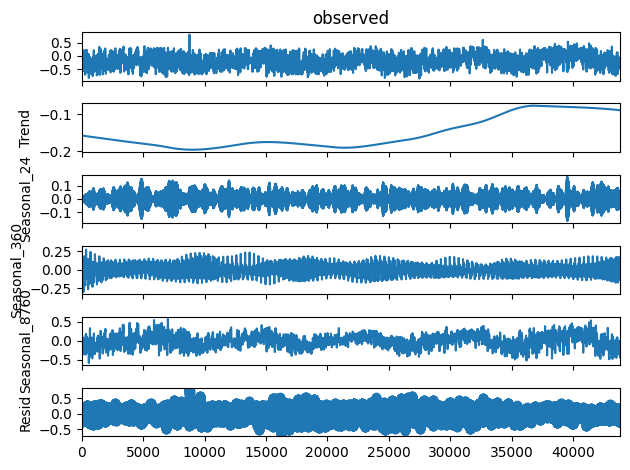

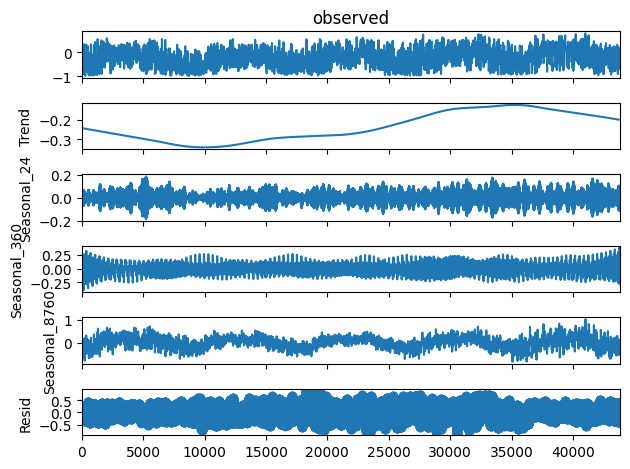

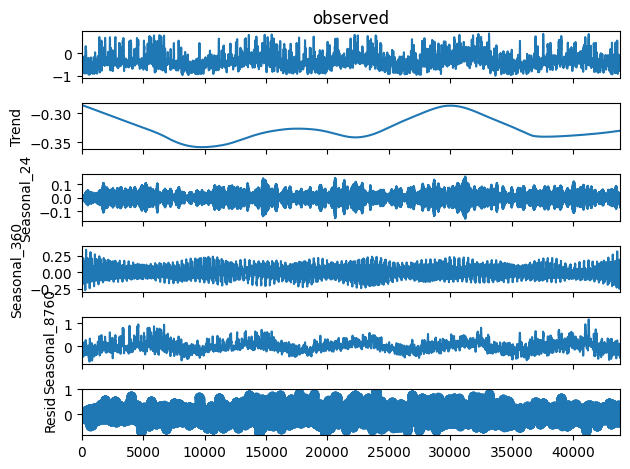

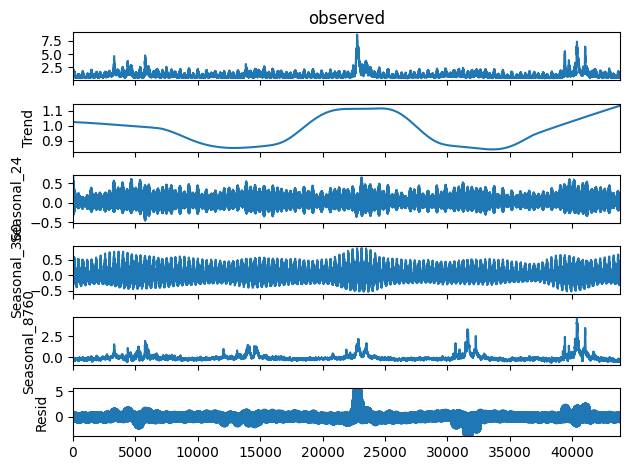

In [74]:
# WIND SPD HORIZNOTAL
my_mstl(climate_data_yongsan['horizon_dir'], 'yongsan_hor')
my_mstl(climate_data_yeongdeungpo['horizon_dir'], 'yeongdeungpo_hor')
my_mstl(climate_data_cemetery['horizon_dir'], 'cemetery_hor')
print("----------")
# WIND SPD VERTICAL
my_mstl(climate_data_yongsan['vertical_dir'], 'yongsan_ver')
my_mstl(climate_data_yeongdeungpo['vertical_dir'], 'yeongdeungpo_ver')
my_mstl(climate_data_cemetery['vertical_dir'], 'cemetery_ver')
print("----------")
# WATER LEVEL
my_mstl(water_level['lvl'], 'water_level')
print("----------")

NameError: name 'my_mstl' is not defined

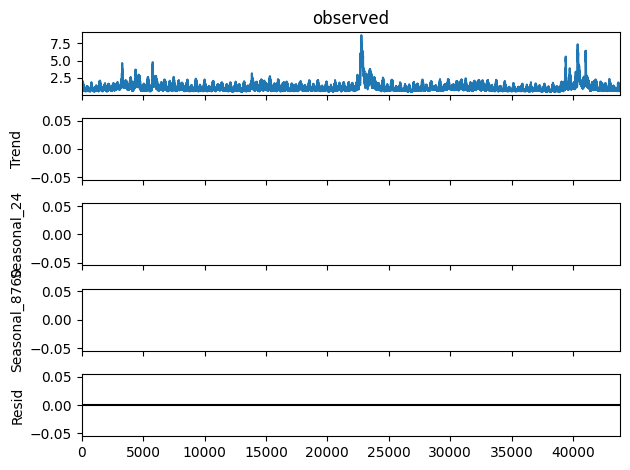

#### JUST A TEST

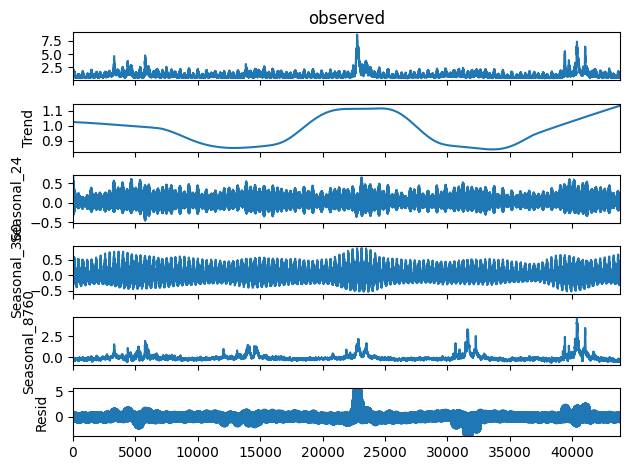

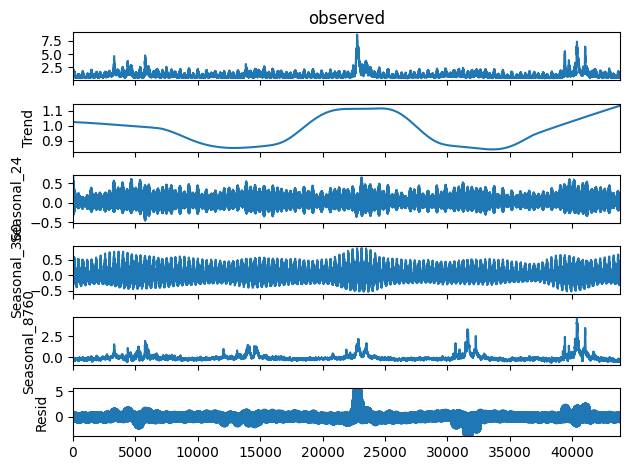

In [49]:
#### Period might include FOUR patterns...!!!!
#### Trying to decompose into FOUR components

mstl = MSTL(water_level['lvl'], periods=[24, 24*15, 24*365])
mstl_data = mstl.fit()
mstl_data.plot()

In [ ]:
### 24*25 = 600

<Axes: >

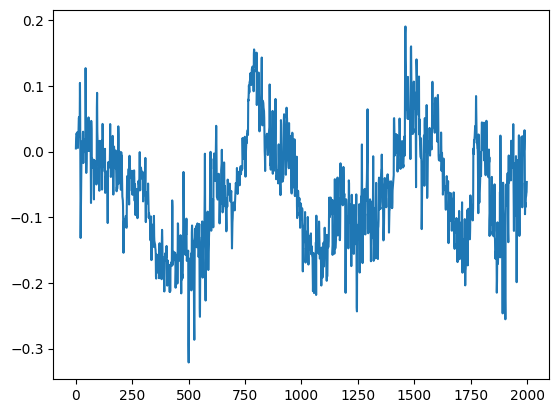

In [55]:
res = mstl_data.resid
res.iloc[:2000].plot()

<Axes: >

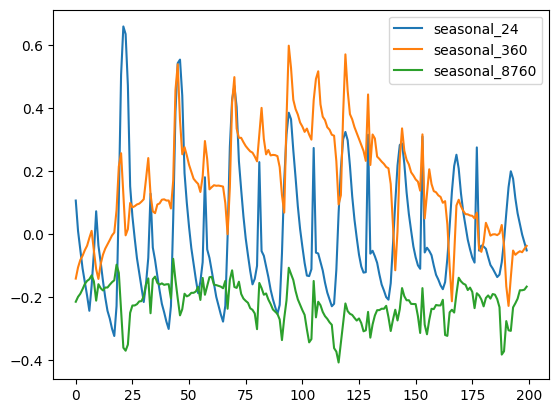

In [59]:
seas = mstl_data.seasonal
seas.iloc[:200].plot()

<Axes: xlabel='time'>

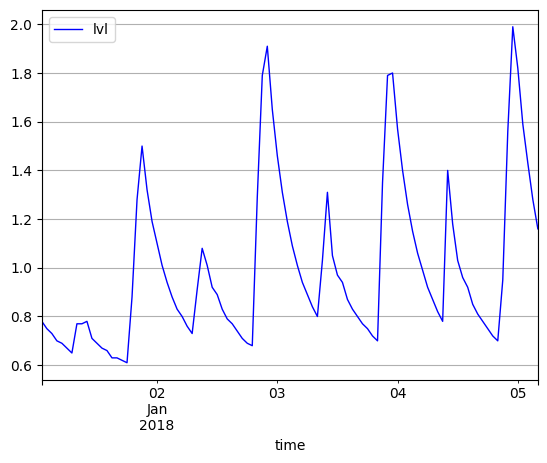

In [57]:
water_level.iloc[:100].plot(
    kind = "line", 
    x = "time", y = "lvl",
    color = "blue",
    lw = 1,
    grid = True,
)

#### 실험용ㅎㅎ

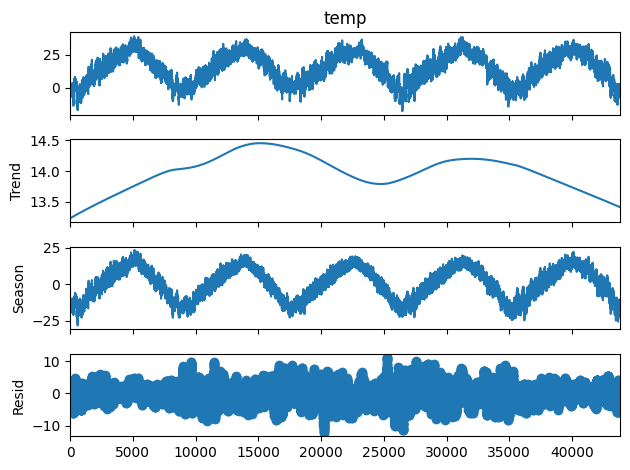

In [324]:
stl_yongsan_temp = STL(climate_data_yongsan['temp'], period = 8760).fit() # 24h * 365d
stl_yongsan_temp.plot()

In [343]:
stl_yongsan_temp_trend = stl_yongsan_temp.trend.to_frame()
stl_yongsan_temp_seasonal = stl_yongsan_temp.seasonal.to_frame()
stl_yongsan_temp_residual = stl_yongsan_temp.resid.to_frame()
stl_yongsan_temp_df = pd.concat([stl_yongsan_temp_trend, stl_yongsan_temp_seasonal, stl_yongsan_temp_residual, climate_data_yongsan['time']], axis = 1)
stl_yongsan_temp_df.head(30)
stl_yongsan_temp_df.to_csv('stl_yongsan_temp.csv')

# 빙이 거

using KZ-filter.. which is applicable on geological data, forcasting, etc...

### 1.4.1. Weather AWS Data .. only precipitation(just for now)

Perhaps the decomposition methods are developed only for univariate case... hence chose the most critical parameter among AWS data variables (어떡하지!!!)... WAIT, just apply the filter on each variable?(ignore the correlations)

In [73]:
climate_data_precip = climate_data[["time", "precip"]]
print(climate_data_precip.head())

              time  precip
0  2018-01-01 1:00     0.0
1  2018-01-01 2:00     0.0
2  2018-01-01 3:00     0.0
3  2018-01-01 4:00     0.0
4  2018-01-01 5:00     0.0


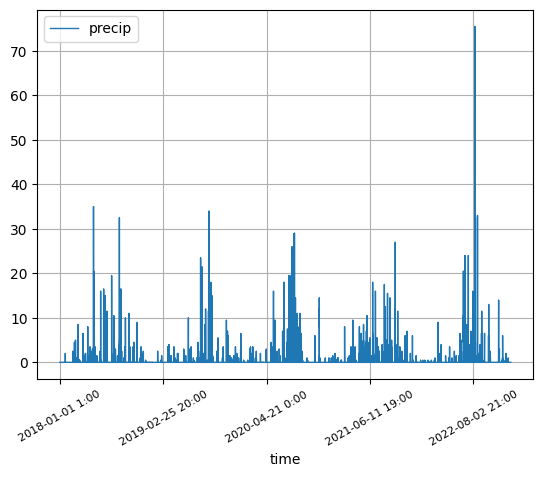

In [75]:
climate_data_precip.plot(
    kind = "line",
    x = "time",
    y = "precip",
    lw = 1,
    grid = True
)
plt.xticks(rotation = 30, fontsize = 8)
plt.show()

In [144]:
# To apply this on each variable, it is necessary to make into a function

t = np.array(climate_data_precip.loc[:, "time"])
precip = np.array(climate_data_precip.loc[:, "precip"])



m, k = 101*24, 3
w = int(k*(m-1)/2)
print(t[w+1:-w].size, kz_filter(precip, m, k).size)

climate_data_precip_KZ1 = pd.DataFrame({
    "time": t[w+1:-w],
    "KZ(%d, %d)"%(m,k): kz_filter(precip, m, k)
})

36358 36358


In [145]:
print(climate_data_precip_KZ1)

                   time  KZ(2424, 3)
0      2018-06-01 12:00     0.190483
1      2018-06-01 13:00     0.190509
2      2018-06-01 14:00     0.190535
3      2018-06-01 15:00     0.190561
4      2018-06-01 16:00     0.190587
...                 ...          ...
36353   2022-08-02 9:00     0.425638
36354  2022-08-02 10:00     0.425642
36355  2022-08-02 11:00     0.425645
36356  2022-08-02 12:00     0.425648
36357  2022-08-02 13:00     0.425651

[36358 rows x 2 columns]


In [146]:
m, k = 21*24, 5
w = int(k*(m-1)/2)
print(t[w+1:-w].size, kz_filter(precip, m, k).size)

climate_data_precip_KZ2 = pd.DataFrame({
    "time": t[w+1:-w],
    "KZ(%d, %d)"%(m, k): kz_filter(precip, m, k)
})

41112 41112


In [147]:
print(climate_data_precip_KZ2)

                   time  KZ(504, 5)
0      2018-02-22 11:00    0.063521
1      2018-02-22 12:00    0.063660
2      2018-02-22 13:00    0.063798
3      2018-02-22 14:00    0.063937
4      2018-02-22 15:00    0.064075
...                 ...         ...
41107  2022-11-09 10:00    0.058729
41108  2022-11-09 11:00    0.058763
41109  2022-11-09 12:00    0.058798
41110  2022-11-09 13:00    0.058833
41111  2022-11-09 14:00    0.058867

[41112 rows x 2 columns]


In [148]:
climate_data_precip_KZ = pd.merge(
    climate_data_precip,
    climate_data_precip_KZ1,
    left_on = "time",
    right_on = "time",
    how = "left"
)
climate_data_precip_KZ = pd.merge(
    climate_data_precip_KZ,
    climate_data_precip_KZ2,
    left_on = "time",
    right_on = "time",
    how = "left"
)

In [149]:
print(climate_data_precip_KZ)

                   time  precip  KZ(2424, 3)  KZ(504, 5)
0       2018-01-01 1:00     0.0          NaN         NaN
1       2018-01-01 2:00     0.0          NaN         NaN
2       2018-01-01 3:00     0.0          NaN         NaN
3       2018-01-01 4:00     0.0          NaN         NaN
4       2018-01-01 5:00     0.0          NaN         NaN
...                 ...     ...          ...         ...
43622  2022-12-31 19:00     0.0          NaN         NaN
43623  2022-12-31 20:00     0.0          NaN         NaN
43624  2022-12-31 21:00     0.0          NaN         NaN
43625  2022-12-31 22:00     0.0          NaN         NaN
43626  2022-12-31 23:00     0.0          NaN         NaN

[43627 rows x 4 columns]


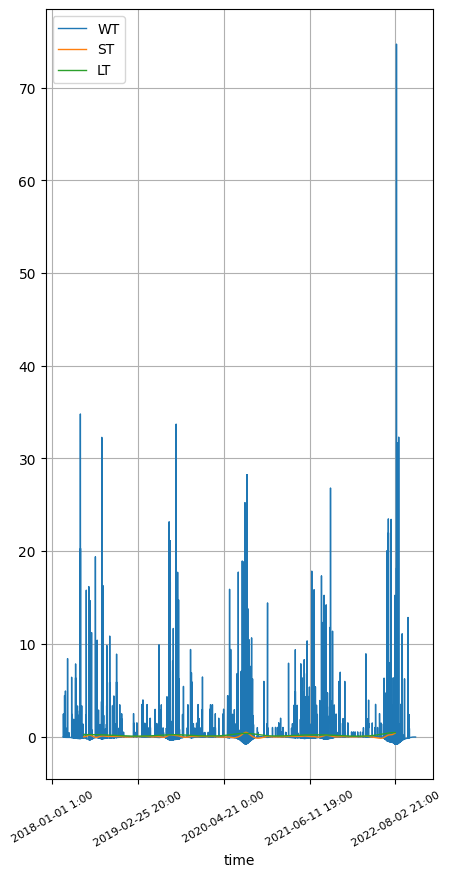

In [153]:
climate_data_precip_KZ["LT"] = climate_data_precip_KZ["KZ(2424, 3)"]
climate_data_precip_KZ["ST"] = climate_data_precip_KZ["KZ(504, 5)"] - climate_data_precip_KZ["KZ(2424, 3)"]
climate_data_precip_KZ["WT"] = climate_data_precip_KZ["precip"] - climate_data_precip_KZ["KZ(504, 5)"]

climate_data_precip_KZ.plot(
    kind = "line",
    x = "time",
    y = ["WT", "ST", "LT"],
    lw = 1,
    grid = True,
    figsize=(5,10)
)
plt.xticks(rotation = 30, fontsize = 8)
plt.show()


...what the heck  분해하는 의미가 있을까? any meaningful properties...?

### 14.2 Water Level Decomposition

In [154]:
t = np.array(water_level.loc[:, "time"])
lvl = np.array(water_level.loc[:, "lvl"])



m, k = 101*24, 3
w = int(k*(m-1)/2)
print(t[w+1:-w].size, kz_filter(lvl, m, k).size)

water_level_KZ1 = pd.DataFrame({
    "time": t[w+1:-w],
    "KZ(%d, %d)"%(m,k): kz_filter(lvl, m, k)
})

36554 36554


In [155]:
print(water_level_KZ1)

                   time  KZ(2424, 3)
0      2018-06-01 12:00     1.127955
1      2018-06-01 13:00     1.128033
2      2018-06-01 14:00     1.128111
3      2018-06-01 15:00     1.128189
4      2018-06-01 16:00     1.128267
...                 ...          ...
36549   2022-08-02 9:00     1.411708
36550  2022-08-02 10:00     1.411819
36551  2022-08-02 11:00     1.411930
36552  2022-08-02 12:00     1.412040
36553  2022-08-02 13:00     1.412150

[36554 rows x 2 columns]


In [162]:
m, k = 21*24, 5
w = int(k*(m-1)/2)
print(t[w+1:-w].size, kz_filter(lvl, m, k).size)

water_level_KZ2 = pd.DataFrame({
    "time": t[w+1:-w],
    "KZ(%d, %d)"%(m,k): kz_filter(lvl, m, k)
})

41308 41308


In [163]:
print(water_level_KZ2)

                   time  KZ(504, 5)
0      2018-02-22 11:00    0.784629
1      2018-02-22 12:00    0.784701
2      2018-02-22 13:00    0.784772
3      2018-02-22 14:00    0.784844
4      2018-02-22 15:00    0.784916
...                 ...         ...
41303  2022-11-09 10:00    0.806739
41304  2022-11-09 11:00    0.806637
41305  2022-11-09 12:00    0.806535
41306  2022-11-09 13:00    0.806433
41307  2022-11-09 14:00    0.806332

[41308 rows x 2 columns]


In [164]:
water_level_KZ = pd.merge(
    water_level,
    water_level_KZ1,
    left_on = "time",
    right_on = "time",
    how = "left"
)
water_level_KZ = pd.merge(
    water_level_KZ,
    water_level_KZ2,
    left_on = "time",
    right_on = "time",
    how = "left"
)

In [165]:
print(water_level_KZ)

             date  hours   lvl              time  KZ(2424, 3)  KZ(504, 5)
0      2018-01-01      1  0.78   2018-01-01 1:00          NaN         NaN
1      2018-01-01      2  0.75   2018-01-01 2:00          NaN         NaN
2      2018-01-01      3  0.73   2018-01-01 3:00          NaN         NaN
3      2018-01-01      4  0.70   2018-01-01 4:00          NaN         NaN
4      2018-01-01      5  0.69   2018-01-01 5:00          NaN         NaN
...           ...    ...   ...               ...          ...         ...
43818  2022-12-31     19  0.54  2022-12-31 19:00          NaN         NaN
43819  2022-12-31     20  0.53  2022-12-31 20:00          NaN         NaN
43820  2022-12-31     21  0.53  2022-12-31 21:00          NaN         NaN
43821  2022-12-31     22  0.53  2022-12-31 22:00          NaN         NaN
43822  2022-12-31     23  0.53  2022-12-31 23:00          NaN         NaN

[43823 rows x 6 columns]


In [2]:
water_level_KZ["LT"] = water_level_KZ["KZ(2424, 3)"]
water_level_KZ["ST"] = water_level_KZ["KZ(504, 5)"] - water_level_KZ["KZ(2424, 3)"]
water_level_KZ["WT"] = water_level_KZ["lvl"] - water_level_KZ["KZ(504, 5)"]

water_level_KZ.plot(
    kind = "line",
    x = "time",
    y = ["WT", "ST", "LT"],
    lw = 1,
    grid = True,
    figsize=(5,10)
)
plt.xticks(rotation = 30, fontsize = 8)
plt.show()

NameError: name 'water_level_KZ' is not defined

This one is okay..

## 1.5. Splitting Data

Proceeded with **blocking split**, *not sure the blocking CV is appropriate*

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]


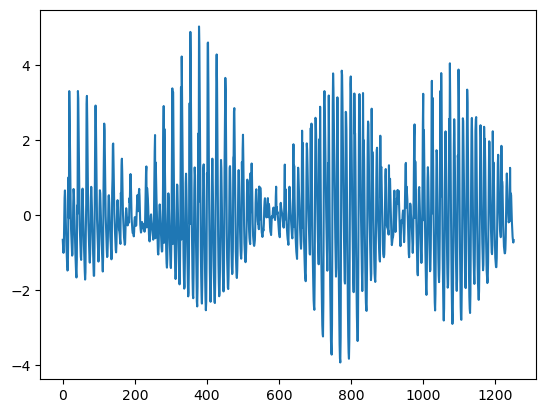

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
tr = []; sn24 = []; sn360 = []; sn8760 = []; re = []
full_data = [tr, sn24, sn360, sn8760, re]
name = ["trend", "seasonal_24", "seasonal_360", "seasonal_8760", "residual"]

for i in range(len(name)):
    comp = name[i]
    for j in range(7):
        x_train = pd.read_csv(f"./pca_data_newofnew/{comp}_data/x_train_{comp}_split{j}.csv")
        y_train = pd.read_csv(f"./pca_data_newofnew/{comp}_data/y_train_{comp}_split{j}.csv")
        x_valid = pd.read_csv(f"./pca_data_newofnew/{comp}_data/x_valid_{comp}_split{j}.csv")
        y_valid = pd.read_csv(f"./pca_data_newofnew/{comp}_data/y_valid_{comp}_split{j}.csv")
        split_data = [x_train, y_train, x_valid, y_valid]
        full_data[i].append(split_data)

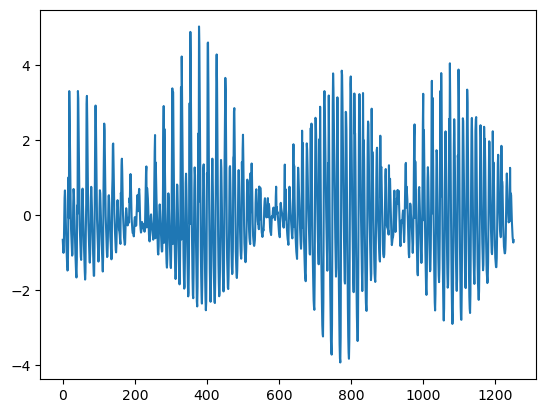

In [7]:
plt.plot(full_data[1][0][3])
# S: 0.303467
# A: 0.909121 과소추정 심하네

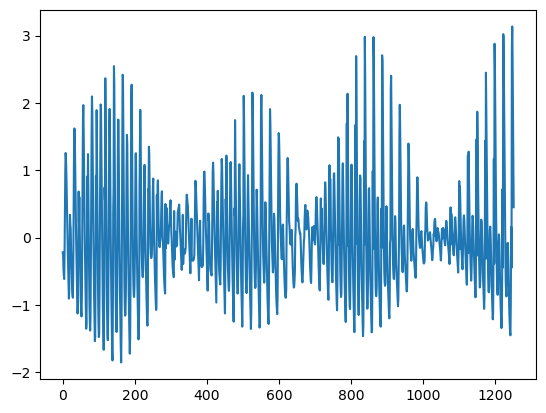

In [8]:
plt.plot(full_data[1][1][3])
# S: 0.100172
# A: 0.296482

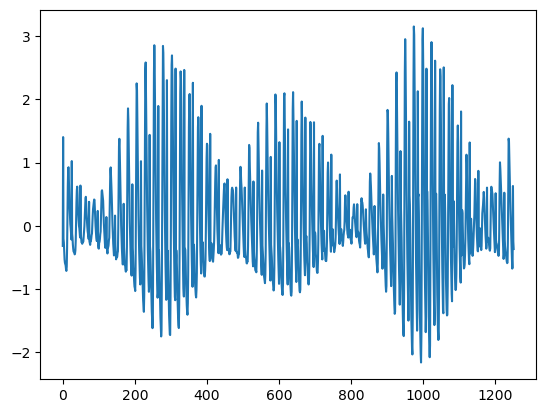

In [9]:
plt.plot(full_data[1][2][3])
# S: 0.030272
# A: 0.247767

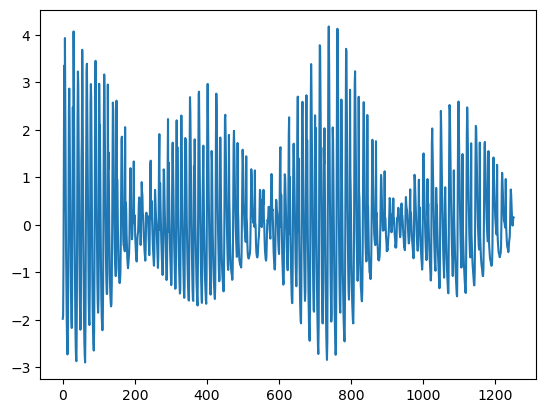

In [10]:
plt.plot(full_data[1][3][3])
# S: 0.120986
# A: 0.403691

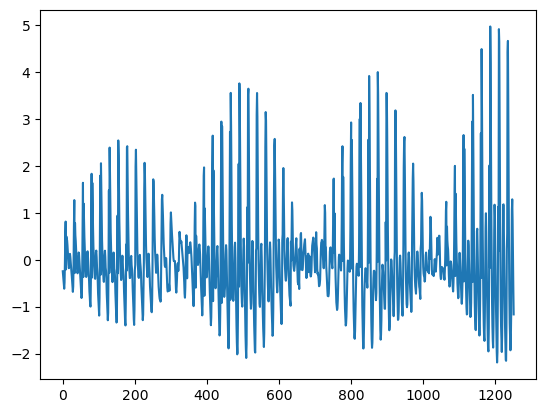

In [11]:
plt.plot(full_data[1][4][3])
# S: 0.245376
# A: 0.531293 과소추정 심하네

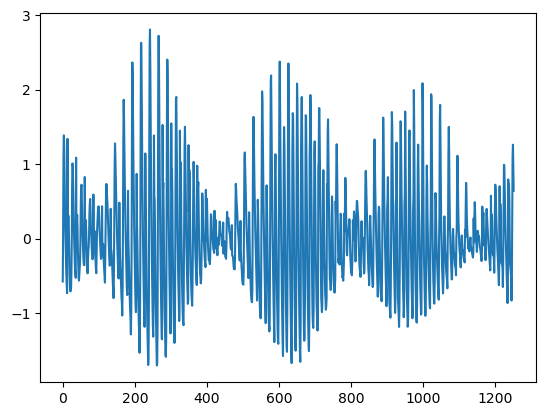

In [12]:
plt.plot(full_data[1][5][3])
# S: 오 개망함 왜지?
# A: 0.207745

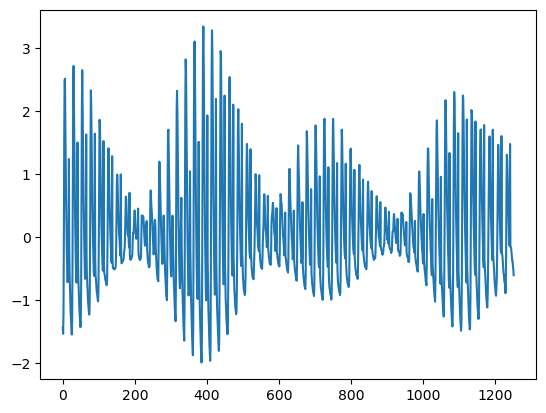

In [13]:
plt.plot(full_data[1][6][3])
# S: 0.056444
# A: 0.208449